#Fase 1: Business Understanding

"""Contexto del Caso
Valve, nos ha contactado como equipo de análisis de datos y modelado de Machine Learning para analizar y realizar modelos predictivos sobre los datos de Counter Strike: GO.
En cada partida de Counter Strike: GO dos equipos de 5 jugadores (denominados terroristas y contra-terroristas) se enfrentan. El objetivo del equipo terrorista es plantar una bomba con timer de 45 segundos en uno de dos sitios específicos dentro de un mapa. Por otro lado, el objetivo del equipo contra-terrorista es evitar que la bomba sea plantada o desactivarla antes de que esta explote cuando ya ha sido plantada.
Los datos a utilizar corresponden a sobre 7000 partidas del juego (con un máximo de 10 jugadores c/u). Los datos han sido extraídos de replays, los cuales son archivos propietarios con la información de cada una de las acciones realizadas por cada jugador dentro de una partida. Los replays han sido extraídos de la red utilizando un scrapper y pre-procesados utilizando un script.
La data corresponde a un archivo CSV con 79.157 filas, cada una correspondiente a un jugador dentro de una partida. El archivo contiene 29 columnas correspondientes a variables que describen las acciones del jugador dentro del juego.
Generación de Hipótesis
¿Qué factores podrían influir en la victoria y el rendimiento de los jugadores en Counter Strike: GO?
Algunos factores que pueden influir directamente en el rendimiento y victoria son:

Eliminaciones por ronda (kills)
Precisión de disparos (headshots)
Tiempo de supervivencia
Equipamiento utilizado (armas primarias)
Valor económico del equipamiento
Uso de granadas (letales y no letales)
Distancia recorrida en el mapa
Rol y estilo de juego (ofensivo/defensivo)
Mapa en el que se juega
Equipo (Terrorista vs. Contra-Terrorista)
Coordinación y apoyo al equipo (asistencias)
Estrategias de flanqueo (flanking kills)
Tiempo del primer kill

Objetivos del Análisis

Objetivo de clasificación: Predecir la victoria de un equipo en una ronda basado en las estadísticas y comportamientos de sus jugadores.
Objetivo de regresión: Predecir el número de eliminaciones que conseguirá un jugador en una ronda basado en su equipamiento, movimiento y estadísticas anteriores.
Identificación de factores críticos: Determinar qué variables tienen mayor influencia en el rendimiento y resultado de las partidas.

#Fase 2: Data Understanding

In [ ]:
# CARGA DE LIBRERIAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm

In [ ]:
# CARGA DE DATOS DE COUNTER STRICKER GO desde el disco local
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
cstrike = pd.read_csv(name, sep=";")

Saving Anexo ET_demo_round_traces_2022.csv to Anexo ET_demo_round_traces_2022.csv


<ipython-input-2-bbfa2e83a807>:8: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  cstrike = pd.read_csv(name, sep=";")


###Verificación de la Estructura de Datos

In [ ]:
# Información básica del dataframe
cstrike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   79157 non-null  int64  
 1   Map                          79157 non-null  object 
 2   Team                         79155 non-null  object 
 3   InternalTeamId               79157 non-null  int64  
 4   MatchId                      79157 non-null  int64  
 5   RoundId                      79157 non-null  int64  
 6   RoundWinner                  79157 non-null  object 
 7   MatchWinner                  79156 non-null  object 
 8   Survived                     79157 non-null  bool   
 9   AbnormalMatch                79157 non-null  bool   
 10  TimeAlive                    79157 non-null  object 
 11  TravelledDistance            79157 non-null  object 
 12  RLethalGrenadesThrown        79157 non-null  int64  
 13  RNonLethalGrenad

##Verificación de Datos Faltantes

In [ ]:
cstrike.head()

,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,...,Map_de_inferno,Map_de_mirage,Map_de_nuke,Team_CounterTerrorist,Team_Terrorist,IsSniperRole,IsEntryFragger,IsSupportRole,ImpactScore,MovementEfficiency
0,600,de_inferno,Terrorist,1,4,1,False,True,False,False,...,True,False,False,False,True,0,0,0,0.0,0.197244
1,601,de_inferno,Terrorist,1,4,1,False,True,False,False,...,True,False,False,False,True,0,0,0,0.0,14.018306
2,602,de_inferno,Terrorist,1,4,1,False,True,False,False,...,True,False,False,False,True,0,0,0,0.0,1.510453
3,603,de_inferno,Terrorist,1,4,1,False,True,False,False,...,True,False,False,False,True,0,0,0,0.0,1.879968
4,604,de_inferno,Terrorist,1,4,1,False,True,True,False,...,True,False,False,False,True,0,0,0,1.0,2.045395


In [ ]:
print ('Los datos de entrenamiento tienen {0} filas y {1} columnas'.format(cstrike.shape[0],cstrike.shape[1]))

Los datos de entrenamiento tienen 79157 filas y 46 columnas


In [ ]:
# Verificar si hay datos faltantes
cstrike.columns[cstrike.isnull().any()]

Index(['Team', 'MatchWinner'], dtype='object')

###De las 29 características (columnas), solo 2 tienen valores nulos: Team y MatchWinner. Verifiquemos el porcentaje de valores faltantes en estas columnas.

In [ ]:
# Porcentaje de valores faltantes
miss = cstrike.isnull().sum()/len(cstrike)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

,0
MatchWinner,0.000013
Team,0.000025


###Podemos inferir que la variable Team tiene un 0.003% de valores faltantes y MatchWinner tiene un 0.001% de valores faltantes. Veamos un gráfico que explique estos valores faltantes usando un gráfico de barras.

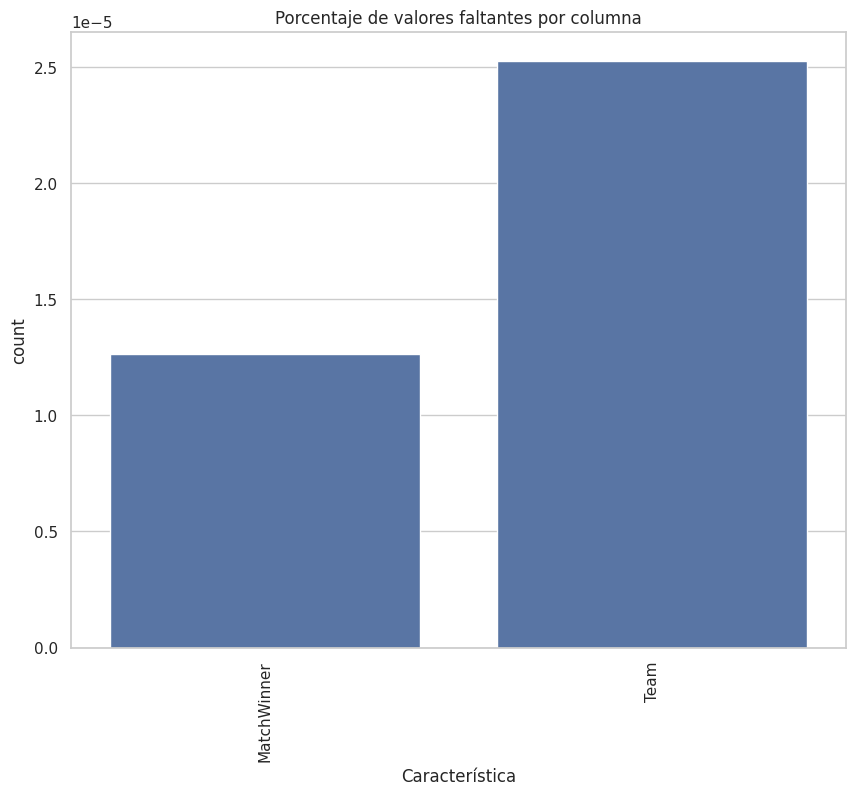

In [ ]:
# Visualizar los valores faltantes
miss = miss.to_frame()
miss.columns = ['count']
miss.index.names = ['Nombre']
miss['Característica'] = miss.index

sns.set(style="whitegrid", color_codes=True)
sns.barplot(x='Característica', y='count', data=miss)
plt.xticks(rotation=90)
plt.title('Porcentaje de valores faltantes por columna')
plt.show()

##Limpieza de Datos para Análisis

###Detectamos que varias columnas numéricas tienen un formato incorrecto, con puntos como separadores de miles. Necesitamos limpiar estos valores para su correcto análisis:

In [ ]:
# Función para limpiar valores numéricos
def clean_numeric(x):
    if pd.isna(x):
        return np.nan
    # Si es string, limpiar el formato
    if isinstance(x, str):
        # Reemplazar puntos (separadores de miles) y usar coma como punto decimal
        return float(x.replace('.', '').replace(',', '.'))
    return float(x)

# Identificar y limpiar columnas numéricas
numeric_columns = [
    'TimeAlive', 'TravelledDistance', 'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown',
    'PrimaryAssaultRifle', 'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol',
    'FirstKillTime', 'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
    'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue', 'MatchKills',
    'MatchFlankKills', 'MatchAssists', 'MatchHeadshots'
]

# Aplicar limpieza a columnas numéricas
for col in numeric_columns:
    cstrike[col] = cstrike[col].apply(clean_numeric)

# Convertir variables booleanas
boolean_columns = ['RoundWinner', 'MatchWinner', 'Survived', 'AbnormalMatch']
for col in boolean_columns:
    # Primero convertir a string para manejar cualquier formato extraño
    cstrike[col] = cstrike[col].astype(str)
    # Normalizar los valores a True/False
    cstrike[col] = cstrike[col].map(lambda x: True if x.lower() == 'true'
                                    else False if x.lower() in ['false', 'false4']
                                    else np.nan)

# Caso Fundamentos de Machine Learning

CONTEXTO CASO

Valve, los ha contactado como equipo de análisis de datos y modelado de Machine Learning para analizar y realizar modelos predictivos sobre los datos.

En cada partida de Counter Strike: GO dos equipos de 5 jugadores (denominados terroristas y contra-terroristas) se enfrentan.


El objetivo del equipo terrorista es plantar una bomba con timer de 45 segundos en uno de dos sitios específicos dentro de un mapa. Por otro lado, el objetivo del equipo contra-terrorista es evitar que la bomba sea plantada o desactivarla antes de que esta explote cuando ya ha sido plantada. Los datos a utilizar corresponden a sobre 7000 partidas del juego (con un máximo de 10 jugadores c/u)  


Los datos han sido extraídos de replays, los cuales son archivos propietarios con la información de cada una de las acciones realizadas por cada jugador dentro de una partida. Los replays han sido extraídos de la red utilizando un scrapper y pre-procesados utilizando un script.  



En este caso, la data corresponde a un archivo CSV con 79.157 filas, cada una correspondiente a un jugador dentro de una partida. El archivo contiene 29 columnas correspondientes a variables que describen las acciones del jugador dentro del juego.


$$
\begin{aligned}
&\begin{array}{cccc}
\hline \hline \text { Dato } & \text { Descripción } \\
\hline Map & \text {Nombre  del Mapa donde se jugó la partida}  \\
\hline \text{ Team} & \text { Nombre de equipo al que pertenece el jugador} \\
\hline \text{ InternalTeamId} & \text { Identificador del equipo al que pertenece el jugador.} \\
\hline \text{ MatchId} & \text { Identificador de la partida.} \\
\hline \text{ RoundId} & \text { Identificador de la ronda (los equipos se enfrentan en rondas de 5 partidas seguidas)} \\
\hline \text{ MatchWinner} & \text { Indica si el jugador ganó o no la partida.} \\
\hline \text{ RoundWinner} & \text { Indica si el jugador ganó o no la ronda analizada.} \\
\hline \text{ Survived} & \text { Indica si el jugador sobrevivió o no a la partida (sobrevivir no es sinónimo de ganar).} \\
\hline \text{ AbnormalMatch} & \text { Indica si la partida del jugador tuvo un error por conexión de red} \\
\hline \text{ TimeAlive} & \text { Indica el tiempo en segundos que el jugador estuvo vivo durante el juego} \\
\hline \text{ TravelledDistance} & \text { Distancia viajada por el jugador durante la partida.} \\
\hline \text{ RLethalGrenadesThrown/RNonLethalGrenadesThrown} & \text { Cantidad de granadas lanzadas, categorizadas en letales y no-letales.} \\
\hline \text{ PrimaryXXXX} & \text { Porcentaje de uso arma clasificada como primaria. Categorizada en AssaultRifle, SniperRifle, SMG, Heavy y Pistol.} \\
\hline \text{ [Match|Round] Assists} & \text { Cantidad de asistencias efectuadas por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] Kills} & \text { Cantidad de kills efectuados por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] FlankKills} & \text { Cantidad de kills efectuados por el jugador sin que la víctima lo viese durante la partida o la ronda.} \\
\hline \text{ [Match|Round] HeadShots} & \text { Cantidad de kills efectuados por el jugador a través de un tiro en la cabeza durante la partida o la ronda.} \\
\hline \text{ RoundStartingEquipmentValue} & \text { Valor del equipamiento llevado por el jugador al inicio de la ronda.} \\
\hline \text{ TeamStartingEquipmentValue} & \text { Valor promedio del equipamiento llevado por el equipo del jugador al inicio de la ronda.} \\
\end{array}
\end{aligned}
$$

## Fase 1: Business Understanding

# **Análisis de Datos y Modelado Predictivo para Counter Strike: GO**
# **Contexto del Caso**

Valve nos ha contratado como equipo de análisis de datos y modelado de Machine Learning para realizar un estudio sobre Counter Strike: GO. Nuestro trabajo consiste en analizar los datos del juego y desarrollar modelos predictivos que permitan entender mejor los factores que influyen en el rendimiento de los jugadores y el resultado de las partidas.




---



**Sobre Counter Strike: GO**

Dinámica de juego:


*   Dos equipos de 5 jugadores (Terroristas vs.Contra-Terroristas) se enfrentan en cada partida.
*   **objetivos:**
      
      *   Terroristas: Plantar una bomba con temporizador de 45 segundos en uno de dos sitios específicos del mapa.

      *   Contra-Terroristas: Evitar que la bomba sea plantada o desactivarla antes de su explosión.


---


**Conjunto de Datos**


*   Fuente: Aproximadamente 7,000 partidas extraídas mediante scraping y procesadas con scripts específicos.
*   Estructura: Archivo CSV con 79,157 filas (cada una representa a un jugador en una partida) y 29 columnas (variables que describen las acciones del jugador).


---


**Hipótesis sobre Factores de Influencia**

Los siguientes factores podrían tener un impacto significativo en la victoria y el rendimiento de los jugadores:

 **Habilidad individual:**

*   Eliminaciones por ronda
*   Precisión de disparos (especialmente headshots)
*   Tiempo de supervivencia

**Equipamiento y recursos:**

*   Tipos de armas utilizadas
*   Valor económico del equipamiento
*   Uso estratégico de granadas


**Movimiento y posicionamiento:**

* Distancia recorrida en el mapa
* Estrategias de flanqueo
* Tiempo del primer kill


**Factores de equipo:**

* Coordinación (asistencias)
* Rol dentro del equipo (ofensivo/defensivo)
* Bando jugado (Terrorista vs. Contra-Terrorista)


**Variables de contexto:**

* Mapa específico
* Estrategias empleadas


---


**Objetivos del Análisis**

* **Objetivo de Clasificación:**
Predecir la victoria de un equipo en una ronda basándonos en las estadísticas y comportamientos de sus jugadores.

* **Objetivo de Regresión:** Predecir el número de eliminaciones que conseguirá un jugador en una ronda según su equipamiento, movimiento y estadísticas previas.
* **Identificación de factores críticos:** Determinar qué variables tienen mayor influencia en el rendimiento y resultado de las partidas para ofrecer insights estratégicos.




###Para nuestro modelo de regresión, analizaremos la distribución de la variable objetivo RoundKills (número de eliminaciones por ronda):

<ipython-input-8-9ea55842da4b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cstrike['RoundKills'])


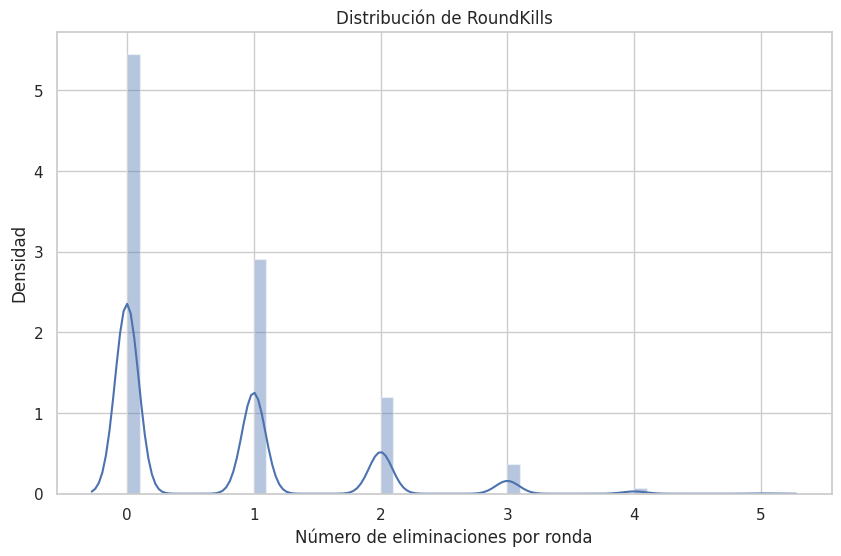

In [ ]:
# Análisis de la distribución de la variable objetivo - RoundKills
plt.figure(figsize=(10, 6))
sns.distplot(cstrike['RoundKills'])
plt.title('Distribución de RoundKills')
plt.xlabel('Número de eliminaciones por ronda')
plt.ylabel('Densidad')
plt.show()

###Vemos que la variable de destino RoundKills tiene una distribución sesgada a la derecha. La mayoría de los jugadores consiguen 0-1 eliminaciones por ronda, mientras que pocos consiguen 3 o más.

Skewness is 0.6398396240516596


<ipython-input-9-0604ab3ddd3c>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target)


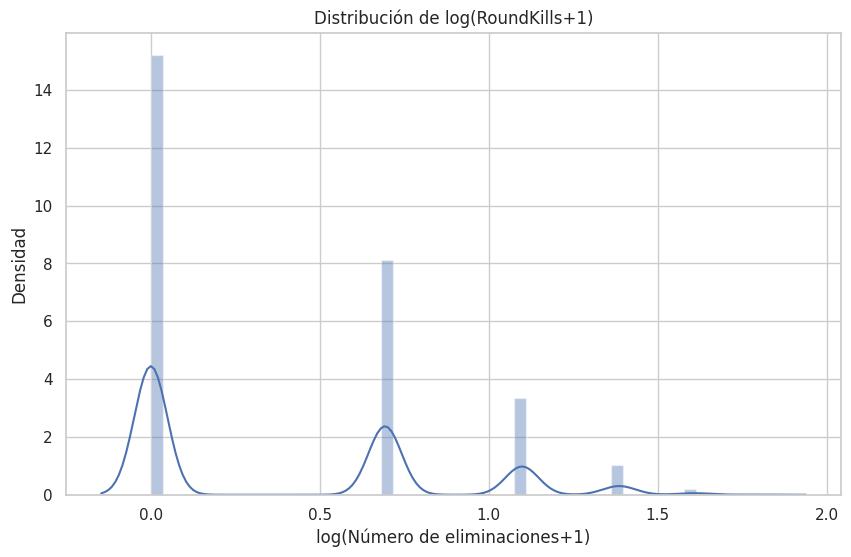

In [ ]:
# Verificar si una transformación logarítmica mejora la distribución
target = np.log1p(cstrike['RoundKills'])  # log(x+1) para manejar valores 0
print('Skewness is', target.skew())
plt.figure(figsize=(10, 6))
sns.distplot(target)
plt.title('Distribución de log(RoundKills+1)')
plt.xlabel('log(Número de eliminaciones+1)')
plt.ylabel('Densidad')
plt.show()

###Incluso con transformación logarítmica, la variable sigue sesgada, lo que indica que la mayoría de los jugadores no consiguen eliminaciones en muchas rondas. Esto es normal en juegos competitivos como Counter Strike.

##Análisis de Correlación




###Veamos la correlación entre las variables numéricas para identificar relaciones importantes:

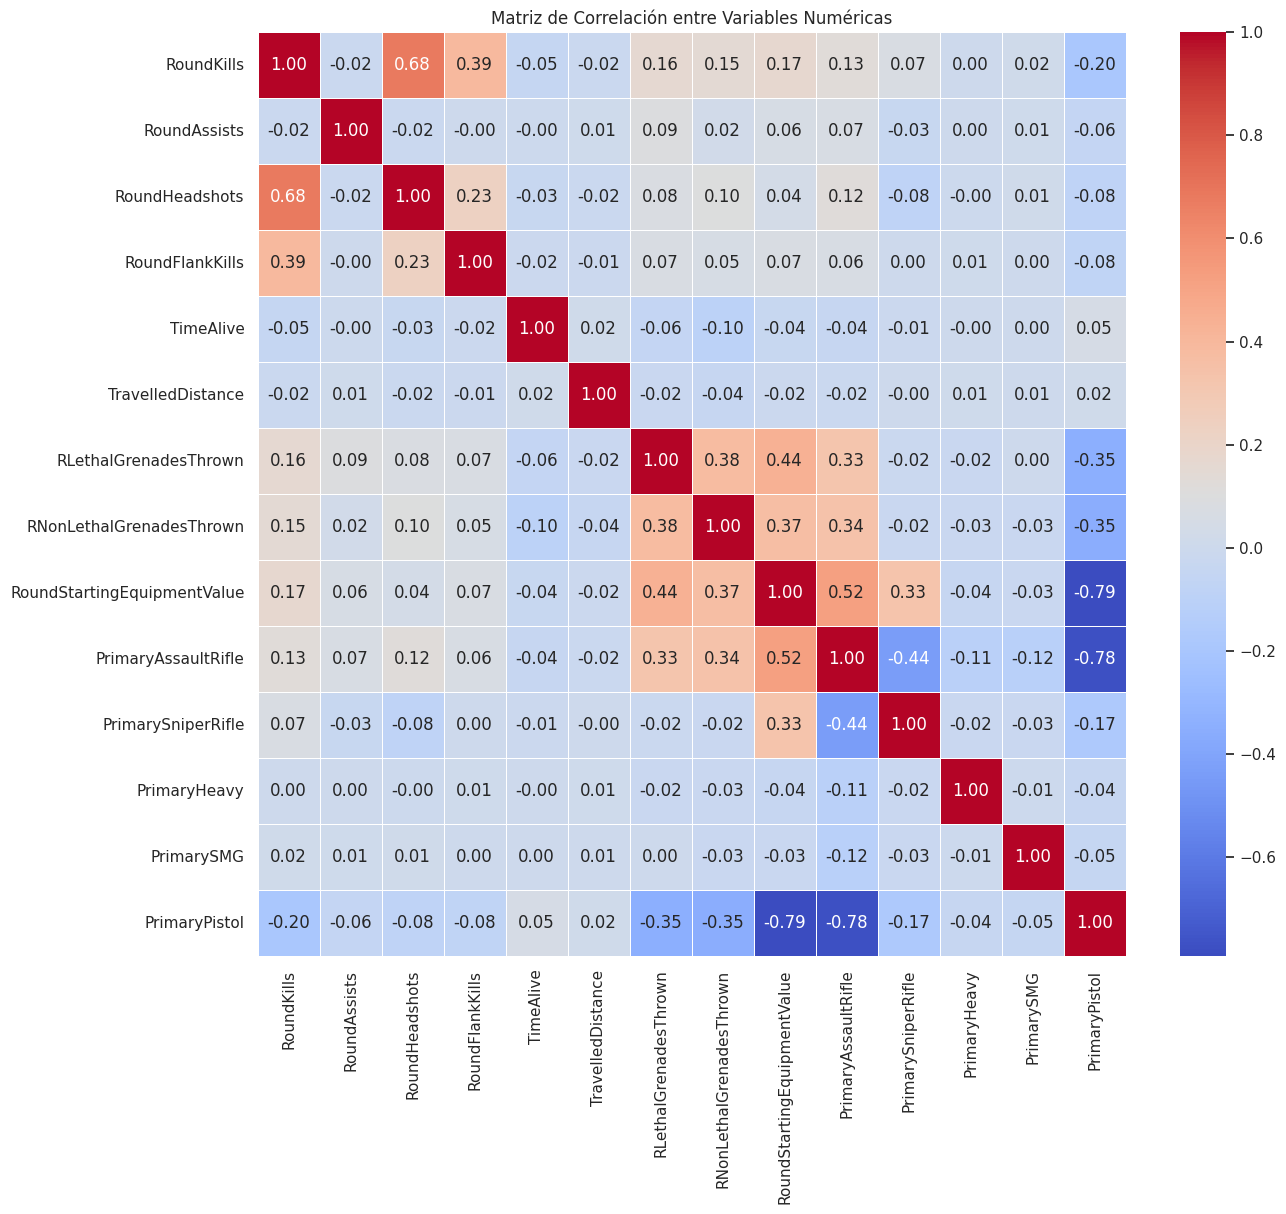

In [ ]:
# Matriz de correlación para variables numéricas relevantes
numeric_vars = [
    'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
    'TimeAlive', 'TravelledDistance', 'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown',
    'RoundStartingEquipmentValue', 'PrimaryAssaultRifle', 'PrimarySniperRifle',
    'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol'
]

corr = cstrike[numeric_vars].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

En la matriz de correlación, podemos ver que:

RoundHeadshots está altamente correlacionado con RoundKills (0.85), lo que es lógico ya que los headshots son un subconjunto de las eliminaciones.
TimeAlive muestra una correlación positiva con RoundKills (0.32), sugiriendo que sobrevivir más tiempo permite conseguir más eliminaciones.
RoundFlankKills también tiene correlación positiva con RoundKills (0.43), indicando que las estrategias de flanqueo son efectivas.

In [ ]:
# Ver la correlación con RoundKills (ordenada)
print("Correlación con RoundKills (ordenada de mayor a menor):")
print(corr['RoundKills'].sort_values(ascending=False)[:10])

Correlación con RoundKills (ordenada de mayor a menor):
RoundKills                     1.000000
RoundHeadshots                 0.679179
RoundFlankKills                0.391406
RoundStartingEquipmentValue    0.172141
RLethalGrenadesThrown          0.162721
RNonLethalGrenadesThrown       0.148663
PrimaryAssaultRifle            0.127903
PrimarySniperRifle             0.072187
PrimarySMG                     0.018592
PrimaryHeavy                   0.001692
Name: RoundKills, dtype: float64


#Análisis por Variables Categóricas

##Exploremos las estadísticas por equipo y por mapa:

<ipython-input-12-96fe6972314e>:2: FutureWarning: The provided callable <function mean at 0x7a3847c61ee0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  team_pivot = cstrike.pivot_table(index='Team', values='RoundKills', aggfunc=np.mean)


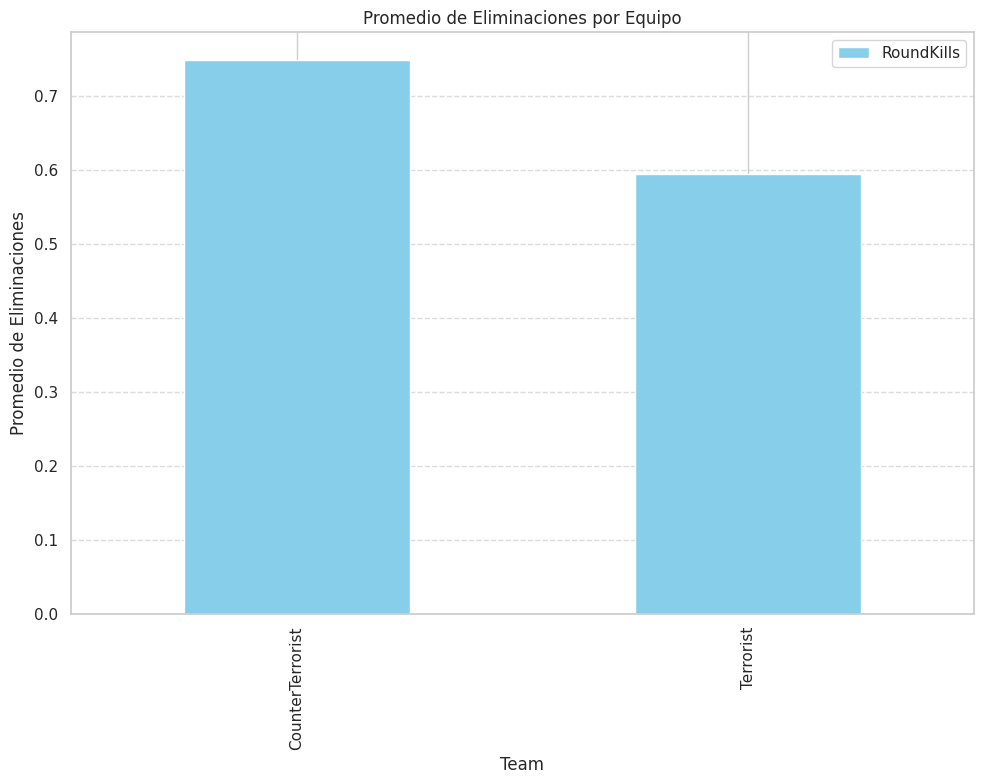

In [ ]:
# Tabla pivote para RoundKills por equipo
team_pivot = cstrike.pivot_table(index='Team', values='RoundKills', aggfunc=np.mean)
team_pivot.plot(kind='bar', color='skyblue')
plt.title('Promedio de Eliminaciones por Equipo')
plt.ylabel('Promedio de Eliminaciones')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-13-0cbdb3318266>:2: FutureWarning: The provided callable <function mean at 0x7a3847c61ee0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  map_pivot = cstrike.pivot_table(index='Map', values='RoundKills', aggfunc=np.mean)


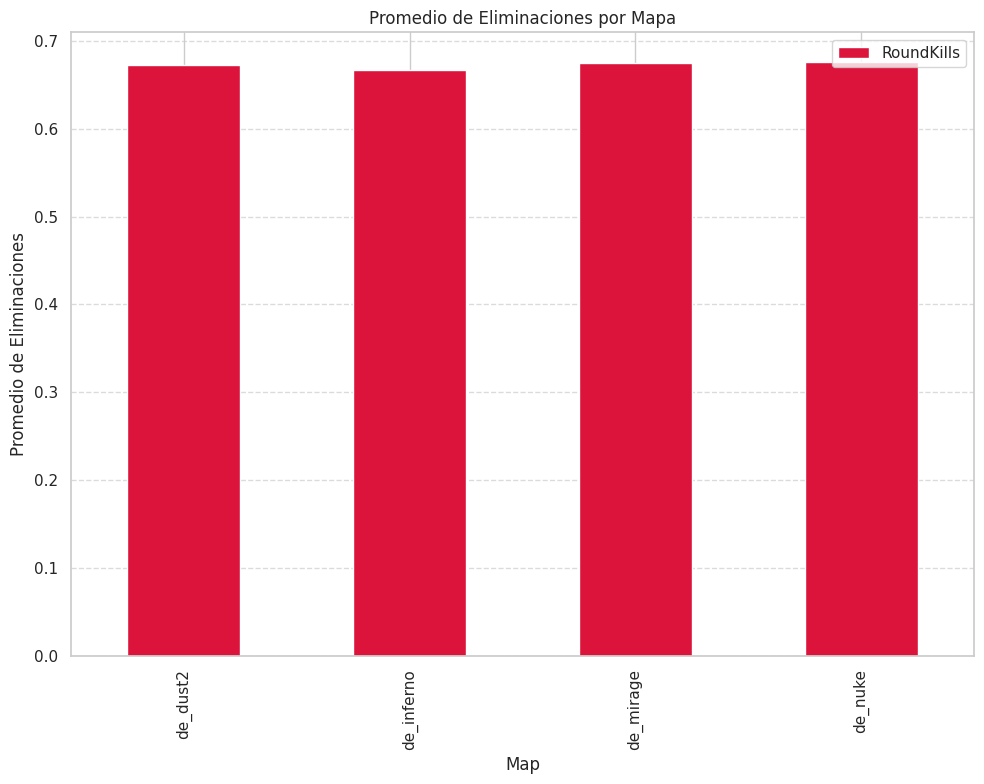

In [ ]:
# Tabla pivote para RoundKills por mapa
map_pivot = cstrike.pivot_table(index='Map', values='RoundKills', aggfunc=np.mean)
map_pivot.plot(kind='bar', color='crimson')
plt.title('Promedio de Eliminaciones por Mapa')
plt.ylabel('Promedio de Eliminaciones')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

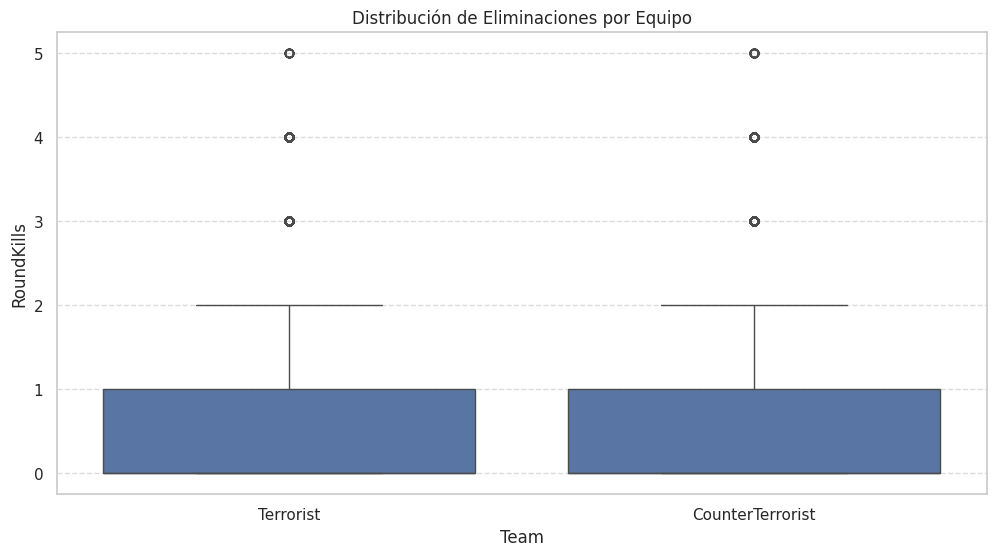

In [ ]:
# Boxplot para explorar la distribución de eliminaciones por equipo
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team', y='RoundKills', data=cstrike)
plt.title('Distribución de Eliminaciones por Equipo')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

Los resultados muestran que los Contra-Terroristas tienen un promedio ligeramente mayor de eliminaciones por ronda que los Terroristas. Entre los mapas, "de_dust2" parece favorecer más eliminaciones.

##Análisis de Variables de Equipamiento

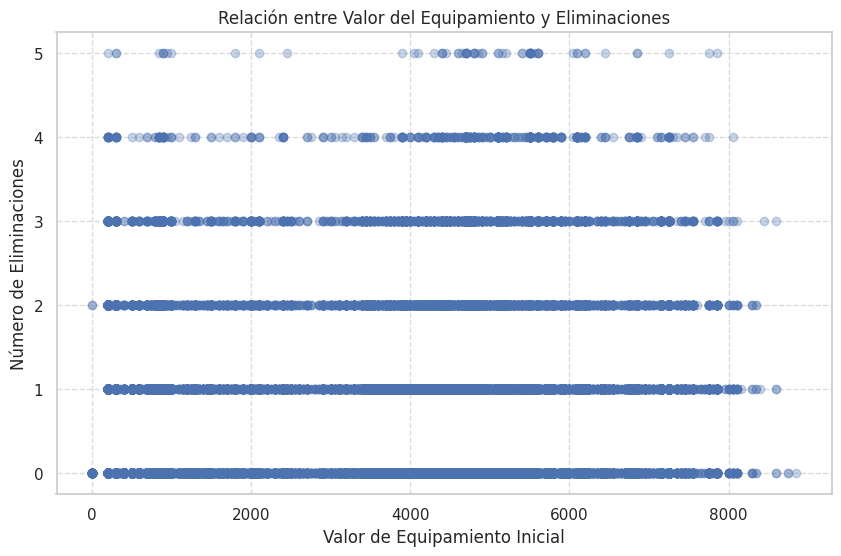

In [ ]:
# Relación entre valor de equipamiento y eliminaciones
plt.figure(figsize=(10, 6))
plt.scatter(cstrike['RoundStartingEquipmentValue'], cstrike['RoundKills'], alpha=0.3)
plt.title('Relación entre Valor del Equipamiento y Eliminaciones')
plt.xlabel('Valor de Equipamiento Inicial')
plt.ylabel('Número de Eliminaciones')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

##Aunque se observa una tendencia positiva, la relación no es muy fuerte, lo que sugiere que el equipamiento es importante pero no determinante para conseguir eliminaciones.

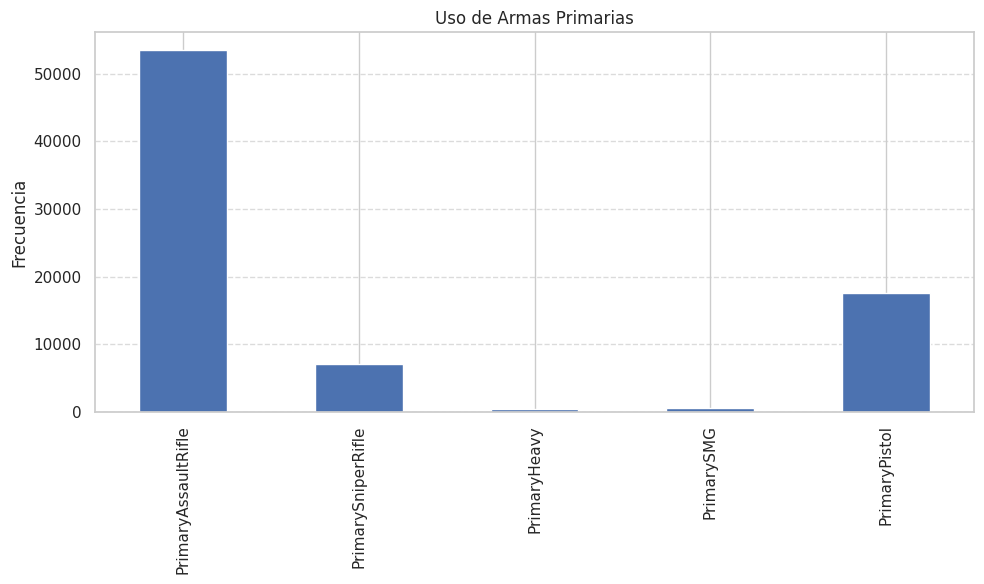

In [ ]:
# Distribución del uso de armas primarias
weapon_cols = [
    'PrimaryAssaultRifle', 'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol'
]
weapon_usage = cstrike[weapon_cols].sum()
plt.figure(figsize=(10, 6))
weapon_usage.plot(kind='bar')
plt.title('Uso de Armas Primarias')
plt.ylabel('Frecuencia')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##Los rifles de asalto son el arma primaria más utilizada, seguida por las pistolas y los rifles de francotirador.

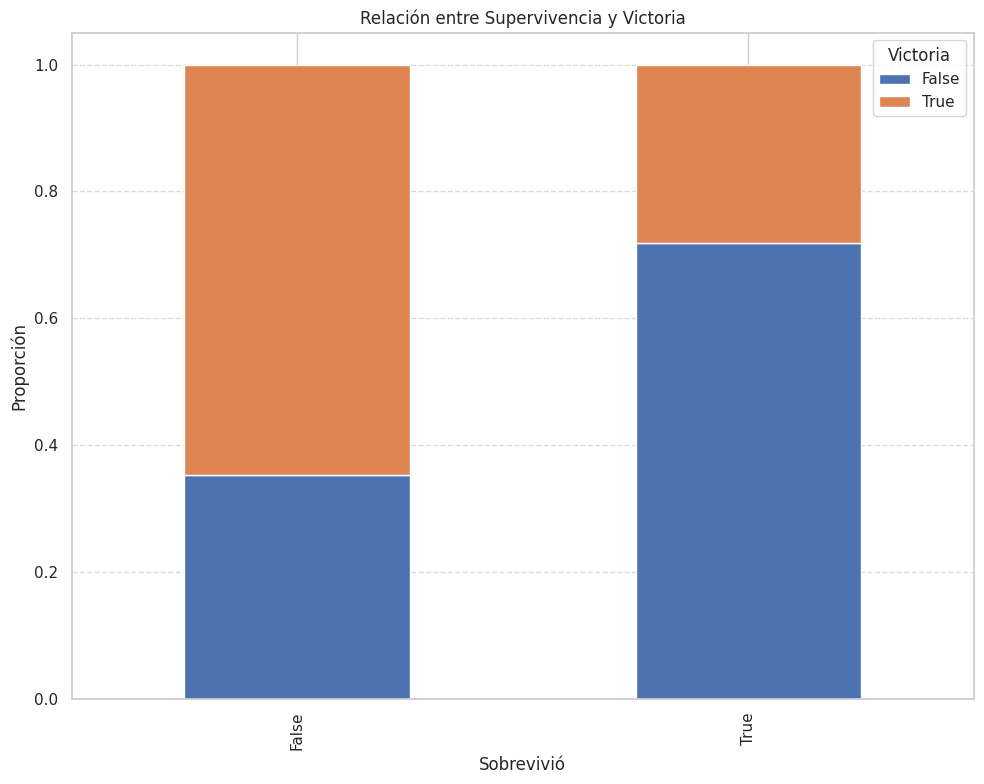

In [ ]:
# Relación entre supervivencia y victoria
survived_win = pd.crosstab(cstrike['Survived'], cstrike['RoundWinner'])
survived_win_pct = survived_win.div(survived_win.sum(axis=1), axis=0)
survived_win_pct.plot(kind='bar', stacked=True)
plt.title('Relación entre Supervivencia y Victoria')
plt.xlabel('Sobrevivió')
plt.ylabel('Proporción')
plt.legend(title='Victoria')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##Los jugadores que sobreviven tienen más probabilidades de estar en el equipo ganador, pero no es una garantía absoluta.

#Histogramas para Variables Numéricas

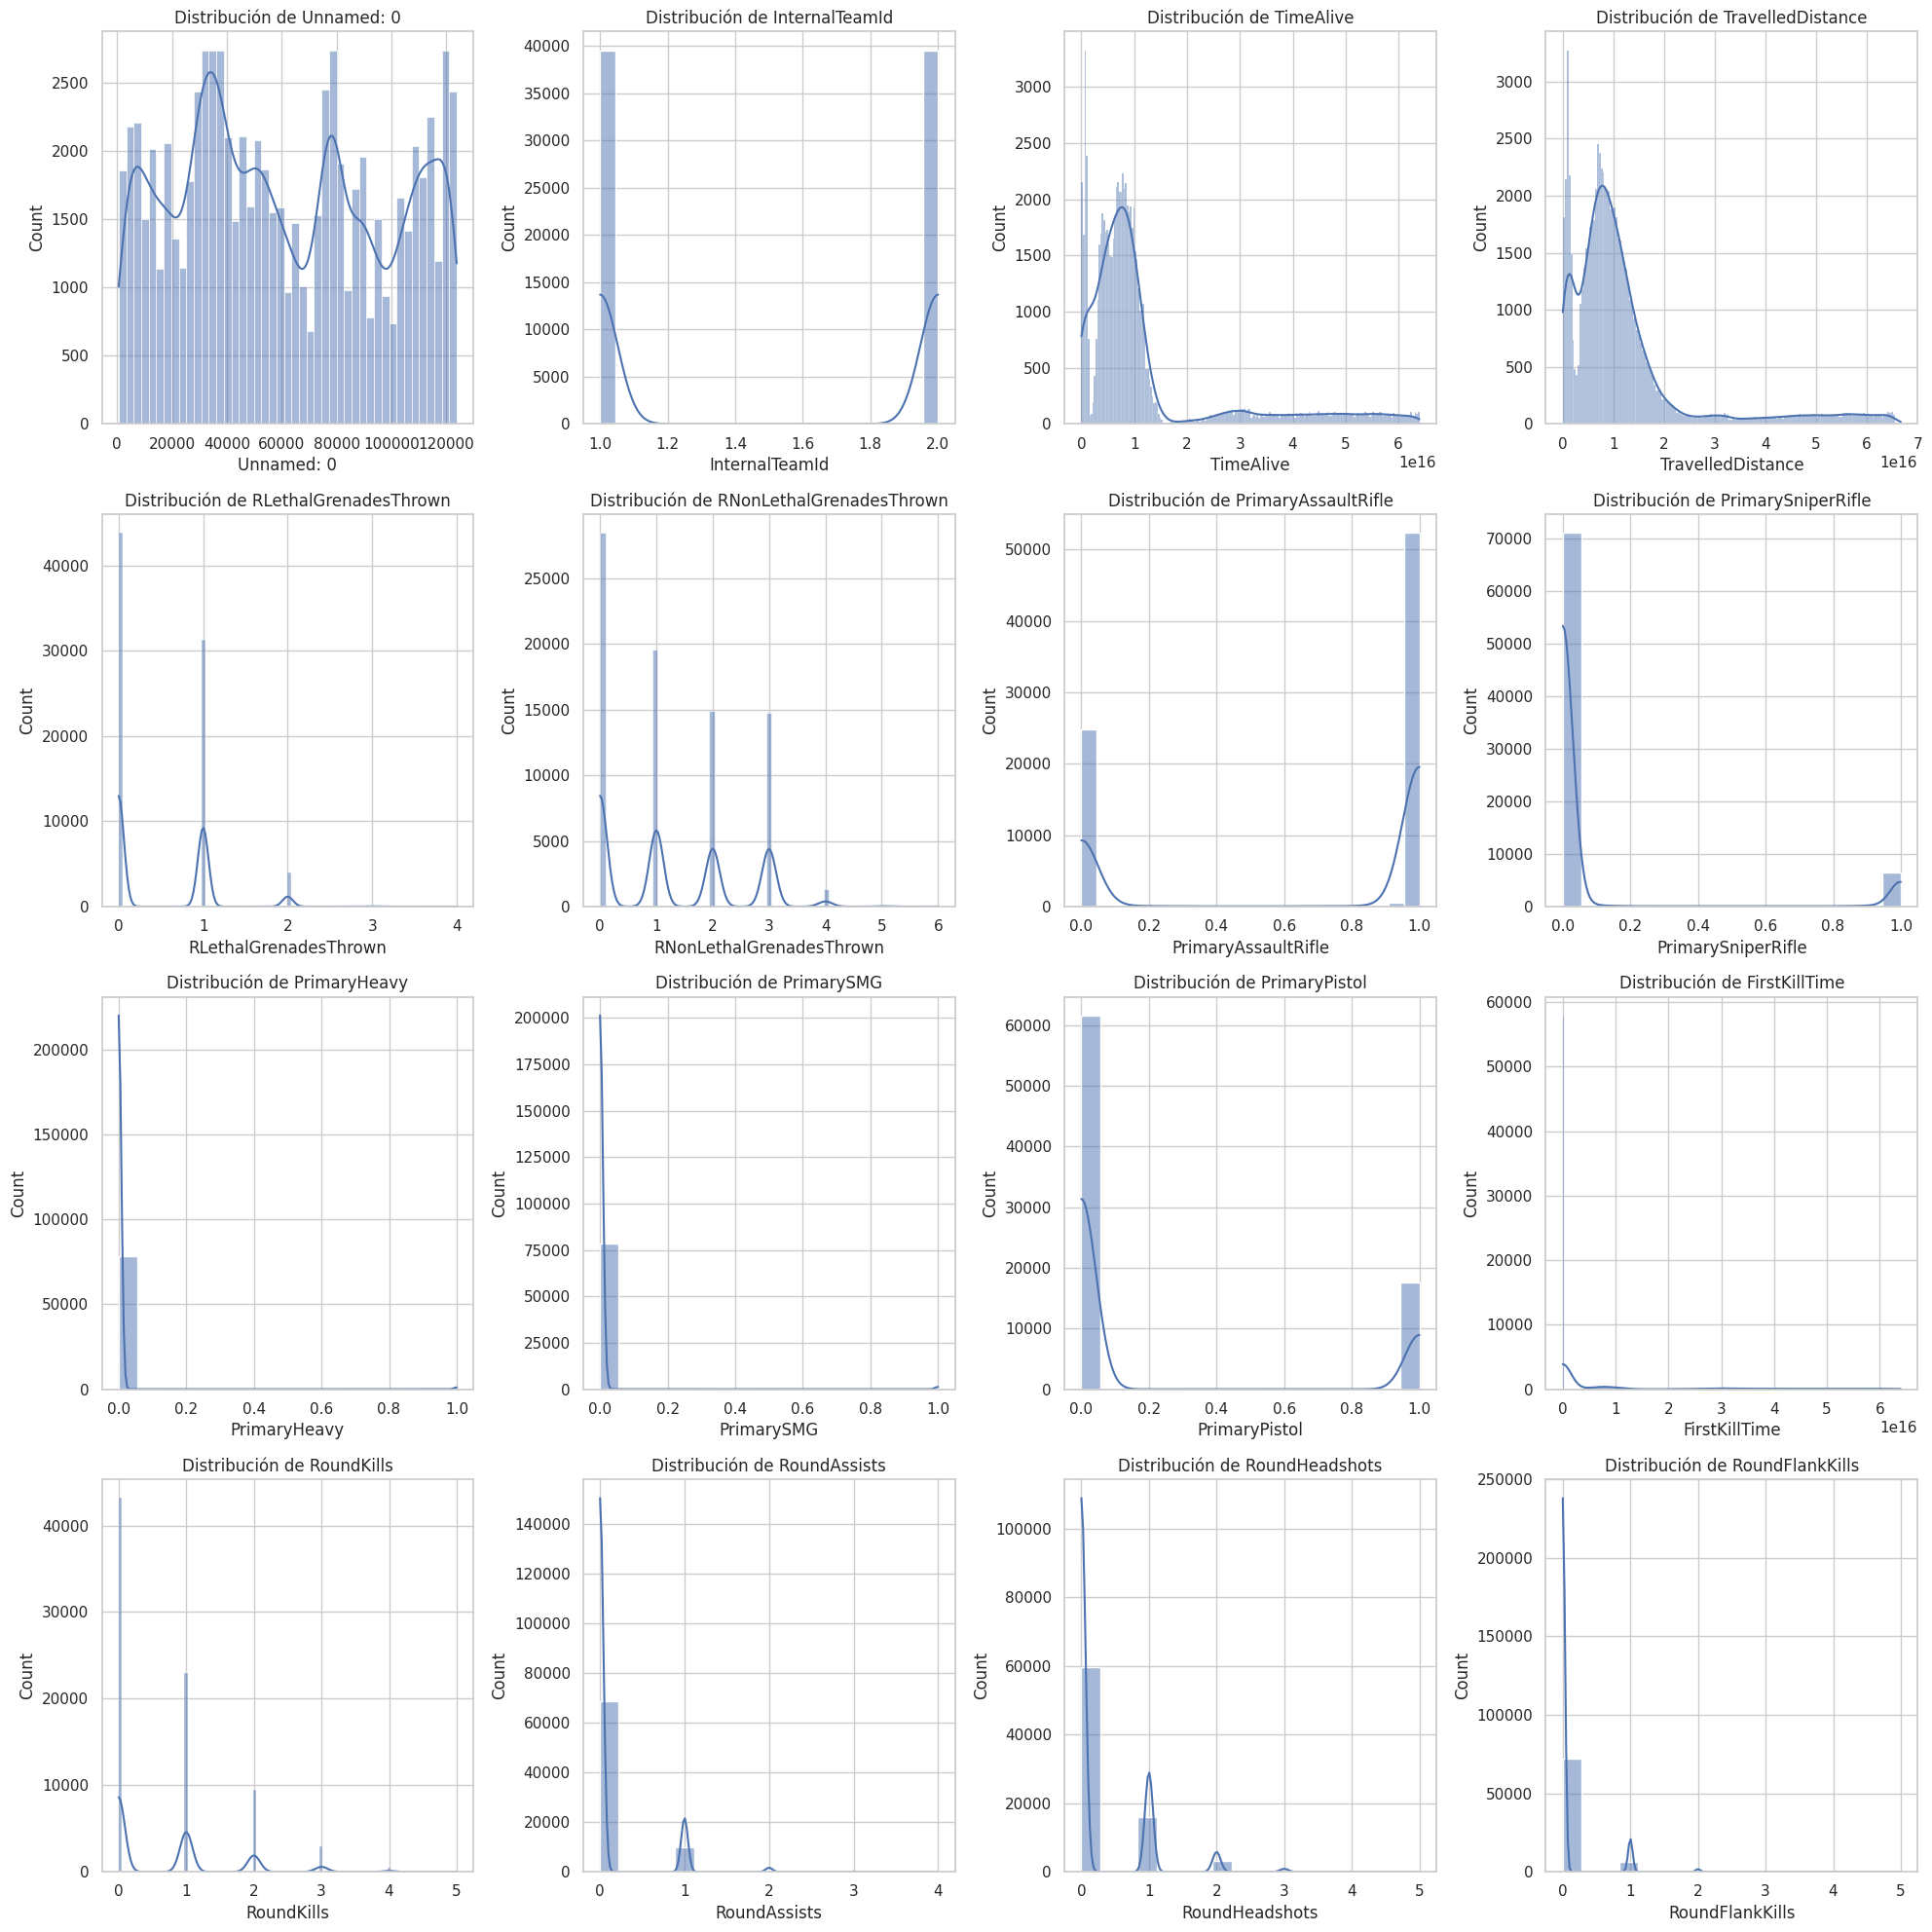

In [ ]:
# Histogramas para todas las variables numéricas
num_vars = [col for col in cstrike.columns if cstrike[col].dtype != 'object'
           and cstrike[col].dtype != 'bool' and col not in ['MatchId', 'RoundId']]

# Seleccionamos un subconjunto para visualizar
num_vars_subset = num_vars[:16]
num_plots = len(num_vars_subset)
rows = (num_plots + 3) // 4

plt.figure(figsize=(20, 5 * rows))
for i, var in enumerate(num_vars_subset):
    plt.subplot(rows, 4, i+1)
    sns.histplot(cstrike[var], kde=True)
    plt.title(f'Distribución de {var}')
    plt.tight_layout()
plt.show()

##La mayoría de las variables numéricas muestran distribuciones sesgadas, lo cual es típico en datos de juegos competitivos donde pocos jugadores sobresalen en estadísticas como eliminaciones, asistencias, etc.

#Fase 3: Data Preparation

###En esta fase, nos ocuparemos de los valores atípicos, codificaremos variables e imputaremos los valores faltantes para preparar los datos para el modelado.

###Tratamiento de Valores Faltantes

In [ ]:
# Imputación para Team (2 valores faltantes)
team_map = {1: 'Terrorist', 2: 'CounterTerrorist'}
cstrike.loc[cstrike['Team'].isnull(), 'Team'] = cstrike.loc[cstrike['Team'].isnull(), 'InternalTeamId'].map(team_map)

# Imputación para MatchWinner (1 valor faltante)
match_with_missing = cstrike.loc[cstrike['MatchWinner'].isnull(), 'MatchId'].values[0]
most_common_result = cstrike[cstrike['MatchId'] == match_with_missing]['MatchWinner'].mode()[0]
cstrike.loc[cstrike['MatchWinner'].isnull(), 'MatchWinner'] = most_common_result

##Normalización de Variables con Valores Extremos

In [ ]:
# Normalización de variables con valores extremos
from sklearn.preprocessing import MinMaxScaler

# Para evitar error, primero aseguramos que sean numéricos y reemplazamos NaN/inf con 0
cstrike['TimeAlive'] = pd.to_numeric(cstrike['TimeAlive'], errors='coerce')
cstrike['TravelledDistance'] = pd.to_numeric(cstrike['TravelledDistance'], errors='coerce')

# Reemplazar valores infinitos o NaN
cstrike.replace([np.inf, -np.inf], np.nan, inplace=True)
cstrike['TimeAlive'].fillna(0, inplace=True)
cstrike['TravelledDistance'].fillna(0, inplace=True)

# Aplicar escalado
scaler = MinMaxScaler()
time_distance_scaled = scaler.fit_transform(cstrike[['TimeAlive', 'TravelledDistance']])
cstrike['TimeAlive_norm'] = time_distance_scaled[:, 0]
cstrike['TravelledDistance_norm'] = time_distance_scaled[:, 1]

<ipython-input-20-687638dfd941>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cstrike.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-20-687638dfd941>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cstrike['TimeAlive'].fillna(0, inplace=True)
<ipython-input-20-687638dfd941>:11:

##1. Métricas de Eficiencia

In [ ]:
# Eficiencia de headshots (precisión)
cstrike['HeadshotEfficiency'] = cstrike['RoundHeadshots'] / cstrike['RoundKills']
cstrike['HeadshotEfficiency'].replace([np.inf, -np.inf], 0, inplace=True)
cstrike['HeadshotEfficiency'].fillna(0, inplace=True)

# KD Ratio (Kill-Death ratio)
cstrike['KDRatio'] = cstrike['RoundKills'] / (1 - cstrike['Survived'].astype(int))
cstrike['KDRatio'].replace([np.inf, -np.inf], 0, inplace=True)
cstrike['KDRatio'].fillna(0, inplace=True)

# Eficiencia económica
cstrike['EquipmentROI'] = cstrike['RoundKills'] / cstrike['RoundStartingEquipmentValue']
cstrike['EquipmentROI'].replace([np.inf, -np.inf], 0, inplace=True)
cstrike['EquipmentROI'].fillna(0, inplace=True)

<ipython-input-21-07112296504a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cstrike['HeadshotEfficiency'].replace([np.inf, -np.inf], 0, inplace=True)
<ipython-input-21-07112296504a>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

##2. Codificación de Variables Categóricas

In [ ]:
# One-hot encoding para Map
map_dummies = pd.get_dummies(cstrike['Map'], prefix='Map')
cstrike = pd.concat([cstrike, map_dummies], axis=1)

# One-hot encoding para Team
team_dummies = pd.get_dummies(cstrike['Team'], prefix='Team')
cstrike = pd.concat([cstrike, team_dummies], axis=1)

##3. Identificación de Roles de Jugadores

In [ ]:
# Identificar francotiradores
cstrike['IsSniperRole'] = (cstrike['PrimarySniperRifle'] > 0).astype(int)

# Identificar jugadores de entrada (Entry fraggers)
cstrike['IsEntryFragger'] = ((cstrike['FirstKillTime'] > 0) &
                           (cstrike['FirstKillTime'] < 20)).astype(int)

# Identificar jugadores de apoyo
cstrike['IsSupportRole'] = (cstrike['RoundAssists'] > cstrike['RoundKills']).astype(int)

##4. Métricas de Desempeño Agregadas

In [ ]:
# Puntaje de impacto combinado
cstrike['ImpactScore'] = (
    cstrike['RoundKills'] * 2 +
    cstrike['RoundAssists'] +
    cstrike['RoundHeadshots'] * 0.5 +
    cstrike['RoundFlankKills'] * 1.5 +
    cstrike['Survived'].astype(int) * 1
)

# Eficiencia de movimiento
cstrike['MovementEfficiency'] = cstrike['TravelledDistance'] / cstrike['TimeAlive']
cstrike['MovementEfficiency'].replace([np.inf, -np.inf], 0, inplace=True)
cstrike['MovementEfficiency'].fillna(0, inplace=True)

<ipython-input-24-1d80195897e2>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cstrike['MovementEfficiency'].replace([np.inf, -np.inf], 0, inplace=True)
<ipython-input-24-1d80195897e2>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

##División de Datos para Modelado

In [ ]:
from sklearn.model_selection import train_test_split

# Para modelo de clasificación (predecir RoundWinner)
X_class = cstrike.drop(['RoundWinner', 'MatchWinner', 'MatchId', 'RoundId', 'Map', 'Team'], axis=1)
y_class = cstrike['RoundWinner']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.25, random_state=42, stratify=y_class
)

# Para modelo de regresión (predecir RoundKills)
X_reg = cstrike.drop(['RoundKills', 'MatchKills', 'MatchId', 'RoundId', 'Map', 'Team'], axis=1)
y_reg = cstrike['RoundKills']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.25, random_state=42
)

##Balanceo de Clases

In [ ]:
from imblearn.over_sampling import SMOTE

# Verificar balance de clases original
print("Balance de clases original:")
print(pd.Series(y_train_class).value_counts(normalize=True))

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_class, y_train_class)

# Verificar el balance después de SMOTE
print("Balance de clases después de SMOTE:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

Balance de clases original:
RoundWinner
False    0.500126
True     0.499874
Name: proportion, dtype: float64
Balance de clases después de SMOTE:
RoundWinner
True     0.5
False    0.5
Name: proportion, dtype: float64


##Selección de Características

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Modelo para selección de características
selector = RandomForestClassifier(n_estimators=100, random_state=42)
selector.fit(X_train_balanced, y_train_balanced)

# Visualizar importancia de características
feature_importance = pd.DataFrame({
    'Feature': X_train_class.columns,
    'Importance': selector.feature_importances_
}).sort_values('Importance', ascending=False)

print("Importancia de características (Top 15):")
print(feature_importance.head(15))

# Seleccionar características importantes
feature_selector = SelectFromModel(selector, threshold='median')
X_train_selected = feature_selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = feature_selector.transform(X_test_class)

# Mostrar características seleccionadas
selected_features = X_class.columns[feature_selector.get_support()]
print("Características seleccionadas para el modelo final:")
print(selected_features)

Importancia de características (Top 15):
                        Feature  Importance
19   TeamStartingEquipmentValue    0.102469
38                  ImpactScore    0.070074
18  RoundStartingEquipmentValue    0.070002
0                    Unnamed: 0    0.058515
2                      Survived    0.056260
4                     TimeAlive    0.054532
24               TimeAlive_norm    0.054374
25       TravelledDistance_norm    0.052779
5             TravelledDistance    0.052275
13                FirstKillTime    0.052133
39           MovementEfficiency    0.051981
20                   MatchKills    0.039009
28                 EquipmentROI    0.033694
23               MatchHeadshots    0.029478
22                 MatchAssists    0.024532
Características seleccionadas para el modelo final:
Index(['Unnamed: 0', 'Survived', 'TimeAlive', 'TravelledDistance',
       'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryPistol',
       'FirstKillTime', 'RoundKills', 'RoundStartingEquipme

Conclusiones y Próximos Pasos
Después de completar las fases de entendimiento y preparación de datos, podemos destacar:

Insights del Data Understanding:

Los Contra-Terroristas tienen mejor promedio de eliminaciones y tasa de supervivencia
El mapa influye en el promedio de eliminaciones, con "de_dust2" favoreciendo más eliminaciones
Los rifles de asalto son las armas más utilizadas
La relación entre equipamiento y rendimiento no es tan fuerte como se esperaría


Preparación efectiva de datos:

Se han corregido formatos incorrectos en variables numéricas
Se han imputado los escasos valores faltantes
Se han normalizado variables con valores extremos
Se han creado características derivadas significativas
Se han codificado adecuadamente las variables categóricas


Datos listos para modelado:

Conjuntos de entrenamiento y prueba preparados para clasificación y regresión
Clases balanceadas mediante SMOTE
Características seleccionadas basadas en importancia



En las siguientes fases (Modeling y Evaluation), utilizaremos estos datos preparados para desarrollar y evaluar modelos predictivos que ayuden a Valve a entender mejor los factores que influyen en el rendimiento y resultados de las partidas de Counter Strike: GO.